<h2>INSTALLAZIONE LIBRERIE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Installazione librerie <strong>necessarie per il funzionamento</strong> del progetto:
</p>

In [1]:
pip install --quiet --upgrade pip scipy matplotlib wordcloud seaborn nltk scikit-learn plotly nbformat imbalanced-learn tqdm xgboost pillow tabulate

Note: you may need to restart the kernel to use updated packages.


<h2>IMPORTAZIONE LIBRERIE</h2>

In [2]:
# Calcolo e manipolazione dati
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import warnings

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

# NLP e Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer 
from collections import Counter

# Gestione degli squilibri di classe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning e Modelli
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metriche di valutazione
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, log_loss, precision_recall_fscore_support, classification_report, accuracy_score, f1_score)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from tabulate import tabulate

# Utility
from sklearn.utils import resample
from tqdm import tqdm  # Barra di avanzamento
import time
from sklearn.exceptions import ConvergenceWarning

# Ignorare avvisi
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", ConvergenceWarning)

<h2>ESPLORAZIONE DEI DATI (EDA)</h2>

In [3]:
# Caricamento Dataset
training_variants = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_variants.csv")
training_text = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','text'])

# Stampa strutturata dei dati
print(f"{'\nDataset':<20}{'(Righe, Colonne)':<30}")
print(f"{'-'*50}")
print(f"{'Training variants':<20}{str(training_variants.shape):<30}")
print(f"{'Training text':<20}{str(training_text.shape):<30}")



Dataset            (Righe, Colonne)              
--------------------------------------------------
Training variants   (3321, 4)                     
Training text       (3321, 2)                     


In [4]:
#unione varianti e testo di addestramento 
df = pd.merge(training_variants, training_text, on = 'ID')
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


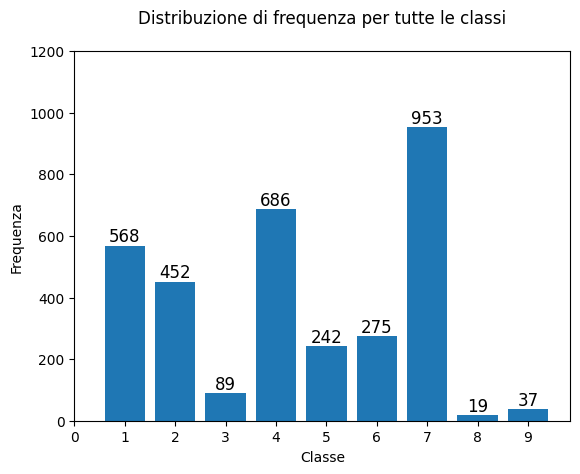

In [5]:
# Conta i valori delle classi e li ordina
plot_dist = df['Class'].value_counts().sort_index()

# Crea il grafico a barre
fig, ax = plt.subplots()

# Crea le barre
bars = ax.bar(plot_dist.index, plot_dist.values)

# Aggiungi il titolo e le etichette
ax.set_title('Distribuzione di frequenza per tutte le classi', loc='center', pad=20)
ax.set_xlabel('Classe')
ax.set_ylabel('Frequenza')

# Aggiungi i valori sopra le barre
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, yval, va='bottom', ha='center', fontsize=12)

# Imposta il limite massimo dell'asse y a 1200
ax.set_ylim(0, 1200)


# Imposta i tick dell'asse x per tutte le classi
ax.set_xticks(range(0, 10))  # Imposta tick per ogni classe

# Mostra il grafico
plt.show()



<h2>PRE-ELABORAZIONE DEL TESTO</h2>

In [6]:
from nltk.stem import PorterStemmer

# Inserimento di altre stop words manualmente adatte al contesto
custom_words = ["fig", "figure", "et", "al", "al.", "also", "data", "analyze", "study", 
                "table", "using", "method", "result", "conclusion", "author", "find", "found", "show"]

# Unione delle stop words di default + la punteggiatura + quelle aggiunte manualmente 
stop_words = set(stopwords.words('english') + list(string.punctuation) + custom_words)

# Inizializzazione dello stemmer
stemmer = PorterStemmer()

def pre_process(text):
    if isinstance(text, float):
        return ''  # Gestione di valori float
    
    text = str(text).lower().strip()
    
    # Rimozione di punteggiatura, HTML e caratteri speciali
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'<.*?>+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenizzazione, rimozione stopwords e stemming
    tokens = word_tokenize(text)
    filtered_tokens = [
        stemmer.stem(word) for word in tokens 
        if word not in stop_words and not word.isdigit() and len(word) > 1  # ignora parole di lunghezza 1
    ]
    
    return ' '.join(filtered_tokens)


def process_corpus(df, text_column, class_column):
    return df.groupby(class_column).apply(lambda x: Counter(word_tokenize(pre_process(x[text_column].str.cat(sep=' ')))))

In [7]:
# Preprocessing dei dati con barra di avanzamento
print("Preprocessing dei dati...")
df['text'] = [pre_process(text) for text in tqdm(df['text'], desc="Preprocessing")]

Preprocessing dei dati...


Preprocessing: 100%|████████████████████████| 3321/3321 [03:27<00:00, 15.98it/s]


In [8]:
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin depend kinas cdk regul varieti fundamen...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evid demonstr acquir uniparent disomi a...
4,4,CBL,L399V,4,oncogen mutat monomer casita lineag lymphoma c...


In [9]:
# Cerchiamo righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text
1109,1109,FANCA,S1088F,1,
1277,1277,ARID5B,Truncating Mutations,1,
1407,1407,FGFR3,K508M,6,
1639,1639,FLT1,Amplification,6,
2755,2755,BRAF,G596C,7,


In [10]:
# Elimina righe con valori nulli o con campo 'text' vuoto
df = df.dropna(subset=["text"]).loc[df['text'] != '']

# Cerchiamo nuovamente righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text


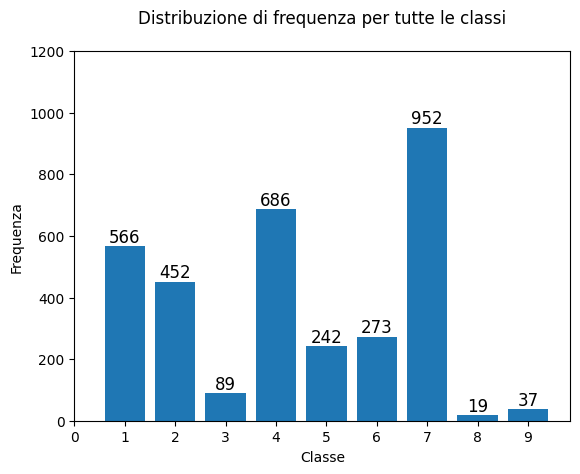

In [11]:
# Conta i valori delle classi e li ordina
plot_dist = df['Class'].value_counts().sort_index()

# Crea il grafico a barre
fig, ax = plt.subplots()

# Crea le barre
bars = ax.bar(plot_dist.index, plot_dist.values)

# Aggiungi il titolo e le etichette
ax.set_title('Distribuzione di frequenza per tutte le classi', loc='center', pad=20)
ax.set_xlabel('Classe')
ax.set_ylabel('Frequenza')

# Aggiungi i valori sopra le barre
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, yval, va='bottom', ha='center', fontsize=12)

# Imposta il limite massimo dell'asse y a 1200
ax.set_ylim(0, 1200)


# Imposta i tick dell'asse x per tutte le classi
ax.set_xticks(range(0, 10))  # Imposta tick per ogni classe

# Mostra il grafico
plt.show()


<h2>ANALISI DELLE FEATURES:</h2>

<h3> - GENI</h3>

In [12]:
unique_genes = df['Gene'].value_counts()

# Stampa del numero di geni unici
print('Numero di Geni Unici:', unique_genes.shape[0])
print(' ')
# Stampa dei top 5 geni più frequenti 
print("Top 5 Geni più frequenti:")
print(' ')
for gene, count in unique_genes.head(5).items():
    print(f'{gene}: {count}')


Numero di Geni Unici: 262
 
Top 5 Geni più frequenti:
 
BRCA1: 264
TP53: 163
EGFR: 141
PTEN: 126
BRCA2: 125


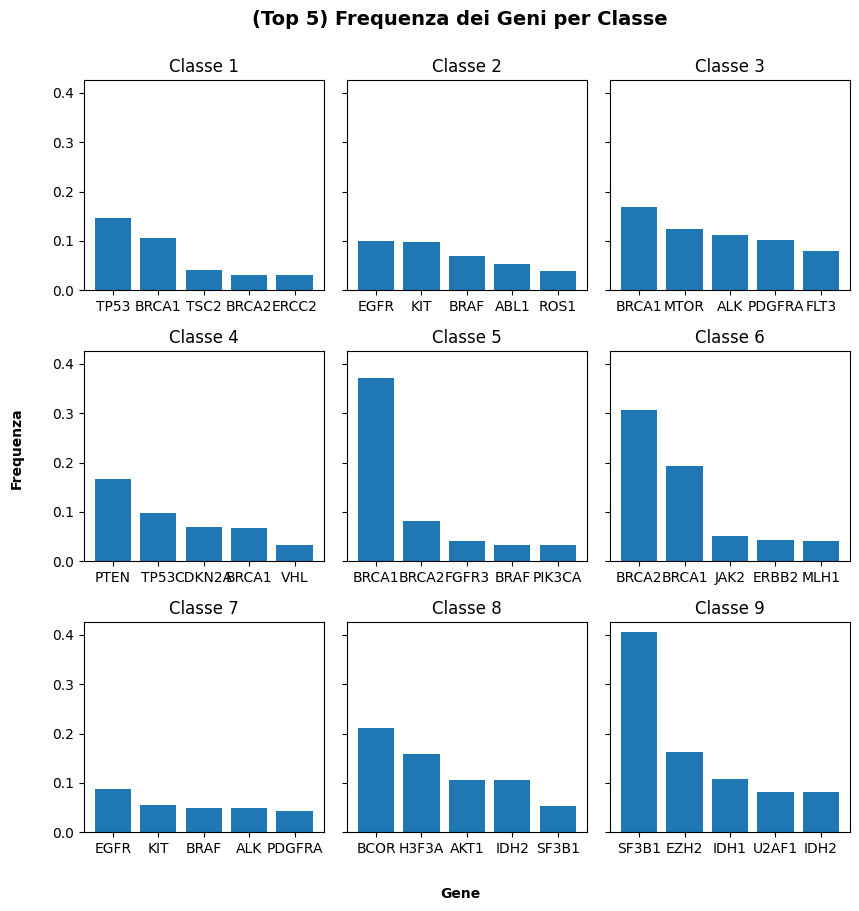

In [13]:
# Creazione dei sottotitoli per il grafico
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 9))

# Normalizzazione dei conteggi per una migliore comparazione
def normalize_group(x):
    label, repetition = x.index, x
    t = sum(repetition)
    r = [n/t for n in repetition]
    return label, r

# Creazione dei grafici per ogni classe
for idx, g in enumerate(df.groupby('Class')):
    label, val = normalize_group(g[1]["Gene"].value_counts())
    ax = axes.flat[idx]
    ax.bar(np.arange(5), val[:5], tick_label=label[:5]) 
    ax.set_title("Classe {}".format(g[0]))

# Etichette
fig.text(0.5, 0.97, '(Top 5) Frequenza dei Geni per Classe', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'Gene', ha='center', fontweight='bold')
fig.text(0, 0.5, 'Frequenza', va='center', rotation='vertical', fontweight='bold')

# Ottimizzazione del layout
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])


<h3> - VARIANTI</h3>

In [14]:
unique_variations = df['Variation'].value_counts()

# Stampa del numero di Varianti uniche
print('Numero di Varianti Uniche:', unique_variations.shape[0])
print(' ')

# Stampa delle top 10 Varianti più frequenti senza "name" e "dtype"
print("Top 5 Varianti più frequenti:")
print(' ')
for variation, count in unique_variations.head(10).items():
    print(f'{variation}: {count}')

Numero di Varianti Uniche: 2993
 
Top 5 Varianti più frequenti:
 
Truncating Mutations: 92
Deletion: 74
Amplification: 70
Fusions: 34
Overexpression: 6
G12V: 4
Q61L: 3
E17K: 3
T58I: 3
Q61R: 3


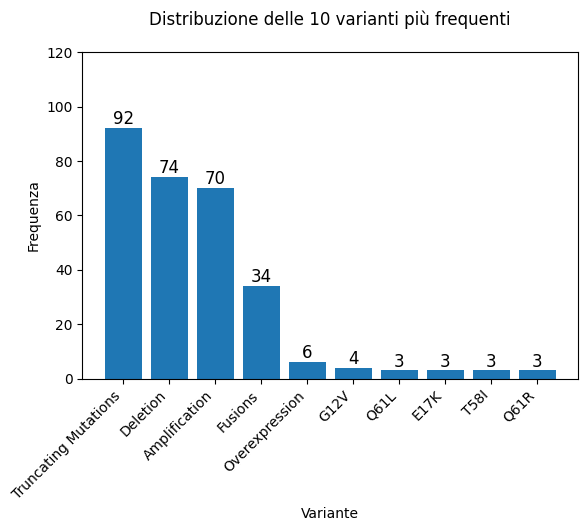

In [15]:
# Conta i valori delle varianti e prendi solo le prime 10 più frequenti
variations_data = df['Variation'].value_counts().head(10)

# Crea il grafico a barre
fig, ax = plt.subplots()

# Crea le barre
bars = ax.bar(variations_data.index, variations_data.values)

# Aggiungi il titolo e le etichette
ax.set_title('Distribuzione delle 10 varianti più frequenti', loc='center', pad=20)
ax.set_xlabel('Variante')  # Titolo dell'asse x
ax.set_ylabel('Frequenza')  # Titolo dell'asse y

# Aggiungi i valori sopra le barre
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, yval, va='bottom', ha='center', fontsize=12)

# Imposta il limite dell'asse y e i tick
ax.set_ylim(0, 120)  # Imposta il limite massimo dell'asse y a 120
ax.set_yticks(range(0, 121, 20))  # Imposta i tick dell'asse y da 0 a 120, con intervallo di 20

# Personalizzazione del font
plt.xticks(rotation=45, ha='right')  # Ruota le etichette dell'asse x se necessario
plt.subplots_adjust(bottom=0.2)  # Aggiungi spazio in basso se le etichette sono lunghe

# Mostra il grafico
plt.show()


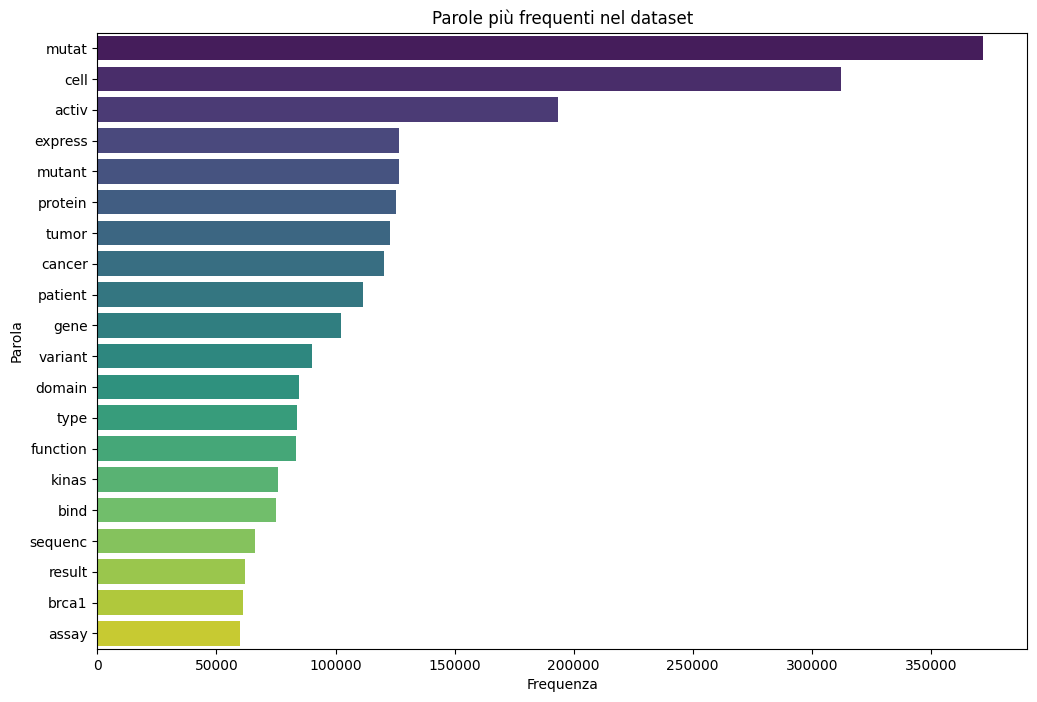

In [16]:

# Unione di tutto il testo in una singola stringa
all_text = ' '.join(df['text'].dropna())

# Tokenizzazione del testo e conteggio delle parole
tokens = all_text.split()  # Dividi il testo in parole
word_counts = Counter(tokens)  # Conta la frequenza di ogni parola

# Converti il conteggio delle parole in un DataFrame ordinato
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Filtra per le parole più frequenti (ad esempio le prime 20)
top_words_df = word_freq_df.head(20)

# Crea il grafico delle parole ordinate per frequenza
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='word', x='frequency', palette='viridis')
plt.xlabel('Frequenza')
plt.ylabel('Parola')
plt.title('Parole più frequenti nel dataset')
plt.show()


<h2> MODELLAZIONE</h2>

In [17]:
# Separazione delle feature e del target
X = df['text']
y = df['Class']

# Funzione per ottenere i modelli
def get_models():
    models = {
        "RF": RandomForestClassifier(),
        "KNN": KNeighborsClassifier(),
        "LR": LogisticRegression(),
        "XGBoost": XGBClassifier()
    }
    return models

In [18]:
# Definizione delle griglie di parametri per i modelli
def get_param_grids():
    param_grids = {
        "RF": {
            "n_estimators": [50, 100, 200],
            "max_depth": [10, 20, 30, None],
        },
        
        "KNN": {
            "n_neighbors": [3, 5, 7],
            "weights": ['uniform', 'distance'],
        },
        
        "LR": {},
        
        "XGBoost": {
            "learning_rate": [0.1], 
            "n_estimators": [50, 100, 150],
            "max_depth": [3, 6, 9],
        }
    }
    return param_grids


In [19]:
# Funzione GridSearch con Cross Validazione
def perform_grid_search(model, X_train, y_train, param_grid):
    # GridSearch con Cross-Validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=0)
    
    # Fitting del modello
    grid_search.fit(X_train, y_train)
    
    # Migliori parametri trovati
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    return best_model, best_params


In [20]:
# Funzione per valutare il modello
def evaluate_model(model, X_test, y_test):
    # Predizioni
    y_pred = model.predict(X_test)
    
    # Calcolo delle metriche
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    
    return precision, recall, f1, accuracy


In [21]:
# Dataset originario diviso in (80/20) train e test con TF-IDF e SVD
def process_original_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    tfidf = TfidfVectorizer(max_features=1000)
    svd = TruncatedSVD(n_components=100)
    
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    X_train_svd = svd.fit_transform(X_train_tfidf)
    X_test_svd = svd.transform(X_test_tfidf)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_svd)
    X_test_scaled = scaler.transform(X_test_svd)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [22]:
# Dataset bilanciato con RandomOverSampler e poi diviso in (80/20) train, test con TF-IDF e SVD
def process_balanced_dataset(X, y):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)
    X_resampled = pd.Series(X_resampled.flatten())
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    tfidf = TfidfVectorizer(max_features=1000)
    svd = TruncatedSVD(n_components=100)
    
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    X_train_svd = svd.fit_transform(X_train_tfidf)
    X_test_svd = svd.transform(X_test_tfidf)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_svd)
    X_test_scaled = scaler.transform(X_test_svd)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [23]:
from sklearn.preprocessing import LabelEncoder

# Funzione per addestrare, ottimizzare e testare i modelli su un dataset specifico
def train_evaluate_model(model, model_name, X, y, dataset_type):
    if dataset_type == "original":
        X_train, X_test, y_train, y_test = process_original_dataset(X, y)
    elif dataset_type == "balanced":
        X_train, X_test, y_train, y_test = process_balanced_dataset(X, y)
    else:
        raise ValueError("Invalid dataset type. Choose 'original' or 'balanced'.")
    
    param_grids = get_param_grids()
    
    # Se si utilizza XGBoost, codifica le etichette
    if model_name == "XGBoost":
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)
        y_test = label_encoder.transform(y_test)
    
    best_model, best_params = perform_grid_search(model, X_train, y_train, param_grids[model_name])
    precision, recall, f1, accuracy = evaluate_model(best_model, X_test, y_test)
    
    # Arrotonda le metriche a 4 cifre decimali
    precision = round(precision, 4)
    recall = round(recall, 4)
    f1 = round(f1, 4)
    accuracy = round(accuracy, 4)
    
    return [model_name, precision, recall, f1, accuracy]


In [24]:
# Sezione per il modello RandomForest
print("Valutazione su set di Test per RandomForest Classifier")
rf_results_original = ["Originale"] + train_evaluate_model(RandomForestClassifier(), "RF", X, y, "original")
rf_results_balanced = ["Bilanciato"] + train_evaluate_model(RandomForestClassifier(), "RF", X, y, "balanced")

rf_results = [rf_results_original, rf_results_balanced]

headers = ["Dataset", "Model", "Precision", "Recall", "F1 Score", "Accuracy"]

print(tabulate(rf_results, headers=headers, tablefmt="grid"))

Valutazione su set di Test per RandomForest Classifier
+------------+---------+-------------+----------+------------+------------+
| Dataset    | Model   |   Precision |   Recall |   F1 Score |   Accuracy |
+============+=========+=============+==========+============+============+
| Originale  | RF      |      0.6191 |   0.6235 |     0.6114 |     0.6235 |
+------------+---------+-------------+----------+------------+------------+
| Bilanciato | RF      |      0.8557 |   0.8571 |     0.8557 |     0.8571 |
+------------+---------+-------------+----------+------------+------------+


In [25]:
# Sezione per il modello KNeighbors
print("\nValutazione su set di Test per KNeighbors Classifier")
knn_results_original = ["Originale"] + train_evaluate_model(KNeighborsClassifier(), "KNN", X, y, "original")
knn_results_balanced = ["Bilanciato"] + train_evaluate_model(KNeighborsClassifier(), "KNN", X, y, "balanced")

knn_results = [knn_results_original, knn_results_balanced]

headers = ["Dataset", "Model", "Precision", "Recall", "F1 Score", "Accuracy"]

# Stampa la tabella formattata
print(tabulate(knn_results, headers=headers, tablefmt="grid"))


Valutazione su set di Test per KNeighbors Classifier
+------------+---------+-------------+----------+------------+------------+
| Dataset    | Model   |   Precision |   Recall |   F1 Score |   Accuracy |
+============+=========+=============+==========+============+============+
| Originale  | KNN     |      0.6033 |   0.6175 |     0.6035 |     0.6175 |
+------------+---------+-------------+----------+------------+------------+
| Bilanciato | KNN     |      0.8375 |   0.8384 |     0.8362 |     0.8384 |
+------------+---------+-------------+----------+------------+------------+


In [26]:
# Sezione per il modello LogisticRegression
print("\nValutazione su set di Test per LogisticRegression Classifier")
lr_results_original = ["Originale"] + train_evaluate_model(LogisticRegression(max_iter=500), "LR", X, y, "original")
lr_results_balanced = ["Bilanciato"] + train_evaluate_model(LogisticRegression(), "LR", X, y, "balanced")

lr_results = [lr_results_original, lr_results_balanced]

headers = ["Dataset", "Model", "Precision", "Recall", "F1 Score", "Accuracy"]

print(tabulate(lr_results, headers=headers, tablefmt="grid"))


Valutazione su set di Test per LogisticRegression Classifier
+------------+---------+-------------+----------+------------+------------+
| Dataset    | Model   |   Precision |   Recall |   F1 Score |   Accuracy |
+============+=========+=============+==========+============+============+
| Originale  | LR      |      0.5531 |   0.5617 |     0.5484 |     0.5617 |
+------------+---------+-------------+----------+------------+------------+
| Bilanciato | LR      |      0.7162 |   0.7217 |     0.7185 |     0.7217 |
+------------+---------+-------------+----------+------------+------------+


In [27]:
# Sezione per il modello XGBoost
print("\nValutazione su set di Test per XGBoost Classifier")
xgb_results_original = ["Originale"] + train_evaluate_model(XGBClassifier(), "XGBoost", X, y, "original")
xgb_results_balanced = ["Bilanciato"] + train_evaluate_model(XGBClassifier(), "XGBoost", X, y, "balanced")

xgb_results = [xgb_results_original, xgb_results_balanced]

headers = ["Dataset", "Model", "Precision", "Recall", "F1 Score", "Accuracy"]

print(tabulate(xgb_results, headers=headers, tablefmt="grid"))


Valutazione su set di Test per XGBoost Classifier
+------------+---------+-------------+----------+------------+------------+
| Dataset    | Model   |   Precision |   Recall |   F1 Score |   Accuracy |
+============+=========+=============+==========+============+============+
| Originale  | XGBoost |      0.6327 |   0.6386 |     0.6294 |     0.6386 |
+------------+---------+-------------+----------+------------+------------+
| Bilanciato | XGBoost |      0.8563 |   0.8576 |     0.8562 |     0.8576 |
+------------+---------+-------------+----------+------------+------------+


In [28]:
from tabulate import tabulate

# Funzione per evidenziare il valore migliore in grassetto
def bold_best_f1(results, metric_index):
    # Filtrare solo i valori numerici per evitare problemi di confronto con stringhe
    numeric_results = [row[metric_index] for row in results if isinstance(row[metric_index], (int, float))]
    
    # Identificare il miglior valore di F1
    best_value = max(numeric_results)
    
    # Evidenziare in grassetto il miglior valore di F1
    for i in range(len(results)):
        if isinstance(results[i][metric_index], (int, float)) and results[i][metric_index] == best_value:
            results[i][metric_index] = f"\033[1m{best_value}\033[0m"
    
    return results

# Lista dei risultati per il dataset non bilanciato
original_results = [
    rf_results_original,
    knn_results_original,
    lr_results_original,
    xgb_results_original
]

# Lista dei risultati per il dataset bilanciato
balanced_results = [
    rf_results_balanced,
    knn_results_balanced,
    lr_results_balanced,
    xgb_results_balanced
]

# Evidenzia il miglior F1-Score per il dataset non bilanciato
original_results = bold_best_f1(original_results, 4)  # Modificato l'indice a 4 per F1-score

# Evidenzia il miglior F1-Score per il dataset bilanciato
balanced_results = bold_best_f1(balanced_results, 4)  # Modificato l'indice a 4 per F1-score

# Stampa la tabella per il dataset non bilanciato
print("\nValutazioni su Dataset Non Bilanciato")
headers = ["Dataset", "Model", "Precision", "Recall", "F1 Score", "Accuracy"]
print(tabulate(original_results, headers=headers, tablefmt="grid"))

# Stampa la tabella per il dataset bilanciato
print("\nValutazioni su Dataset Bilanciato")
print(tabulate(balanced_results, headers=headers, tablefmt="grid"))



Valutazioni su Dataset Non Bilanciato
+-----------+---------+-------------+----------+------------+------------+
| Dataset   | Model   |   Precision |   Recall |   F1 Score |   Accuracy |
+===========+=========+=============+==========+============+============+
| Originale | RF      |      0.6191 |   0.6235 |     0.6114 |     0.6235 |
+-----------+---------+-------------+----------+------------+------------+
| Originale | KNN     |      0.6033 |   0.6175 |     0.6035 |     0.6175 |
+-----------+---------+-------------+----------+------------+------------+
| Originale | LR      |      0.5531 |   0.5617 |     0.5484 |     0.5617 |
+-----------+---------+-------------+----------+------------+------------+
| Originale | XGBoost |      0.6327 |   0.6386 |     0.6294 |     0.6386 |
+-----------+---------+-------------+----------+------------+------------+

Valutazioni su Dataset Bilanciato
+------------+---------+-------------+----------+------------+------------+
| Dataset    | Model   | 